# Romanian painting retrieval

# 1) Test romanian database

-> extract 200 pictures and memorize their output

In [79]:
import cv2
import matplotlib.pyplot as plt
import glob
import os
import shutil
import numpy as np
import torch.nn as nn
import torch
import torchvision.transforms as transforms
import pandas as pd


from torch import Generator
from torch.utils.data import Dataset, DataLoader, Subset, random_split, SubsetRandomSampler
from sklearn.model_selection import train_test_split

In [80]:
mobile_net = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mobile_net.to(device)

for param in mobile_net.parameters():
    param.requires_grad = False

mobile_net.classifier[1] = nn.Linear(in_features=1280, out_features=18, bias=True)

# LOAD NET
mobile_net.load_state_dict(torch.load('mobileNet_PandoraTrain1.pt'))
mobile_net.cuda()
mobile_net.eval()

Using cache found in C:\Users\Teodora/.cache\torch\hub\pytorch_vision_v0.10.0
e:\Programe\Anaconda\envs\Pytorch\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
e:\Programe\Anaconda\envs\Pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [81]:
base_path = "E:\Lucru\ANUL II MASTER\MLAV\ProiectDificil\Pandora_18k_Merged\\"

folders = [ f.path for f in os.scandir(base_path) if f.is_dir() ]
classes_names = [ f.name for f in os.scandir(base_path) if f.is_dir() ]
classes = ["1","2","3","4","5","6","7","8","9","10","11","12","13","14","15","16","17","18"]

class_mapping = {
    "01_Byzantin_Iconography": 0,
    "02_Early_Renaissance":1,
    "03_Northern_Renaissance":2,
    "04_High_Renaissance":3,
    "05_Baroque":4,
    "06_Rococo":5,
    "07_Romanticism":6,
    "08_Realism":7,
    "09_Impressionism":8,
    "10_Post_Impressionism":9,
    "11_Expressionism":10,
    "12_Symbolism":11,
    "13_Fauvism":12,
    "14_Cubism":13,
    "15_Surrealism":14,
    "16_AbstractArt":15,
    "17_NaiveArt":16,
    "18_PopArt" : 17
}

inv_class_mapping = {v: k for k, v in class_mapping.items()}


image_path_by_class = []
aux_str = []

for folder in folders:
    aux_str = folder + "//" + "*.jpg"
    image_path_by_class.append(glob.glob(aux_str))
print(classes_names)

['01_Byzantin_Iconography', '02_Early_Renaissance', '03_Northern_Renaissance', '04_High_Renaissance', '05_Baroque', '06_Rococo', '07_Romanticism', '08_Realism', '09_Impressionism', '10_Post_Impressionism', '11_Expressionism', '12_Symbolism', '13_Fauvism', '14_Cubism', '15_Surrealism', '16_AbstractArt', '17_NaiveArt', '18_PopArt']


In [82]:
labels = []
for index, class_path in enumerate(image_path_by_class):
  tmp = []
  for img_path in class_path:
    label = img_path.split("\\")[6]
    tmp.append(label)
  labels.append(tmp)

# len(labels)
targets = []
for label in labels:
    tmp = []
    for img_label in label:
      tmp.append(img_label)
    targets.append(tmp)


In [83]:
base_path_rom = "E:\Lucru\ANUL II MASTER\MLAV\ProiectDificil\Romanian_paintings\Images\\"

# base_path_rom = "E:\Lucru\ANUL II MASTER\MLAV\ProiectDificil\Romanian_paintings\Net"

folders_rom = [ f.path for f in os.scandir(base_path_rom) if f.is_dir() ]

# print(folders_rom)

In [84]:
import pandas as pd

excel_name = "E:\Lucru\ANUL II MASTER\MLAV\ProiectDificil\Romanian_paintings\\romanian_wikiart_2.xlsx"

df = pd.read_excel(excel_name, sheet_name="Lista-completa")

print(df[['image_id']].loc[0]['image_id'])
print(df[['style']].loc[0]['style'])

adam-baltatu_after-rain
Impressionism


Adrian-Ghenie
E:\Lucru\ANUL II MASTER\MLAV\ProiectDificil\Romanian_paintings\Images\\Adrian-Ghenie\adrian-ghenie_the-sunflowers-in-1937.jpg
Label:  Neo-Expressionism


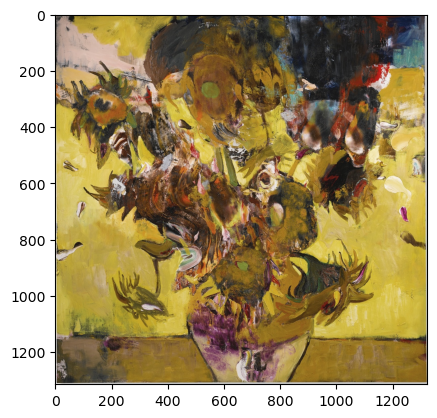

In [85]:
picture_index = 10
artist_index = 100

artist = df[['artist_slug']].loc[artist_index]['artist_slug']
artist = artist.title()
print(artist)

test_picture = base_path_rom + "\\" + artist + "\\" + df[['image_id']].loc[artist_index + picture_index]['image_id'] + ".jpg"
print(test_picture)

img = cv2.imread(test_picture)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure()
plt.imshow(img)
print("Label: ", df[['style']].loc[artist_index + picture_index]['style'])

Real label: Neo-Expressionism
tensor([[-10.9033, -11.0330,  -6.9105,  -9.1835,  -5.7073,  -9.5582,  -6.7910,
          -4.4809,   0.4970,  -1.1175,  -1.6039,  -2.8280,  -3.2640,  -4.3032,
          -1.6937,  -1.1873,  -1.8872,  -0.1487]], grad_fn=<ToCopyBackward0>)
Predicted label:  09_Impressionism


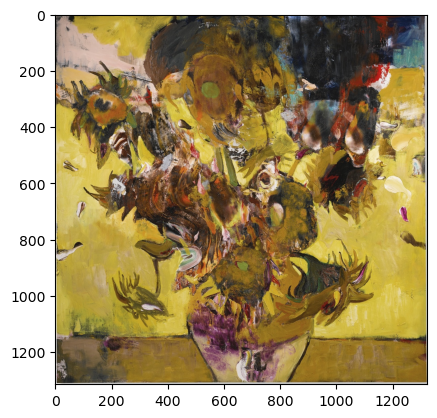

In [86]:
transf = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

picture = 4

# test_img = cv2.imread(train_data[picture])
# test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

img = cv2.imread(test_picture)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure()
plt.imshow(img)
print("Real label:", df[['style']].loc[artist_index + picture_index]['style'])

data = transf(img)
data = data.to(torch.device('cuda'))
data = data[None, :]
# data.size()
# test_label = test_labels[picture].to(torch.device('cuda'))


predict = mobile_net.forward(data)
predict = predict.to(torch.device('cpu'))

print(predict)

predict = np.argmax(predict.detach().numpy(),axis=1)
print("Predicted label: ",inv_class_mapping[predict[0]])


# Extract the desired romanian pictures

Because we have 80 authors we will extract 5 pictures (=> 400 in total) from each author and calculate the features

In [116]:
path_rom = "E:\Lucru\ANUL II MASTER\MLAV\ProiectDificil\Romanian_Paintings_400"


excel_name = "E:\Lucru\ANUL II MASTER\MLAV\ProiectDificil\Romanian_paintings\\romanian_only_features_labels.xlsx"
new_excel_name = "E:\Lucru\ANUL II MASTER\MLAV\ProiectDificil\Romanian_paintings\\romanian_with_features.xlsx"

data_frame = pd.read_excel(excel_name)
features=[]
# df = df.assign(features=[])

transf = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


for index, image in enumerate(data_frame['image_id']):
        picture_path = path_rom + "\\" + image + ".jpg"

        img = cv2.imread(picture_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        data = transf(img)
        data = data.to(torch.device('cuda'))
        data = data[None, :]

        predict = mobile_net.forward(data)
        predict = predict.to(torch.device('cpu'))
        # predict = np.argmax(predict.detach().numpy(),axis=1)
        features.append(predict.detach().numpy())

print(len(features))

data_frame.insert(2,column='features', value=features)
data_frame.to_excel(new_excel_name, index=False)

401


In [133]:
excel_name = "E:\Lucru\ANUL II MASTER\MLAV\ProiectDificil\Romanian_paintings\\romanian_with_features.xlsx"

data_frame = pd.read_excel(excel_name)

test_ft = data_frame['features'].loc[0].split("[[")[1]
test_ft = test_ft.split("]]")[0]

print(test_ft)
print(type(test_ft))

test = np.fromstring(test_ft, dtype=float, count=- 1, sep = ' ')

print(test)
print(type(test))

-7.3846292 -6.0525804 -3.2317517 -6.4154086 -4.5929713 -6.3634105
  -2.4932764 -1.2034115  1.3217235 -0.5450301 -2.0157845 -2.2328591
  -1.3203398 -6.6780596 -2.8827775 -5.7650137 -2.1475587 -5.462954 
<class 'str'>
[-7.3846292 -6.0525804 -3.2317517 -6.4154086 -4.5929713 -6.3634105
 -2.4932764 -1.2034115  1.3217235 -0.5450301 -2.0157845 -2.2328591
 -1.3203398 -6.6780596 -2.8827775 -5.7650137 -2.1475587 -5.462954 ]
<class 'numpy.ndarray'>
